In [6]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.cluster import KMeans
from Utils33 import find_similar_articles, update_embeddings, get_average_embedding, analyze_clusters
from openai import OpenAI
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.options.mode.chained_assignment = None

client = OpenAI(config.OPENAI_API_KEY)
sas_url = config.SAS_URL

In [55]:
update_embeddings(sas_url)

Max date in embedding data is 2023-12-04 03:06:00 --> Need embeddings for 887 new articles. Cost for 71750 tokens will be approx. $0.007175
Embeddings updated.


In [2]:
# import data, transform for analysis

spon_embeddings = pd.read_csv('./data/spon_embeddings.csv')
spon_embeddings['embedding'] = spon_embeddings.embedding.to_numpy()
spon_embeddings['embedding'] = spon_embeddings.embedding.apply(literal_eval).apply(np.array)
print(f'Current data has {len(spon_embeddings)} articles. Last time updated: {spon_embeddings['publish_date'].max()}')

Current data has 75811 articles. Last time updated: 2023-12-11 02:23:00


In [3]:
# take sample for t-SNE plot

channel_count = spon_embeddings.channel.value_counts()
channel_list = channel_count.head(15).index.tolist()
print(channel_list)

spon_embeddings_sample = spon_embeddings[(spon_embeddings.publish_date >= "2023-01-01") & (spon_embeddings.channel.isin(channel_list))].sample(n=10000, random_state=42)

['Ausland', 'Panorama', 'Wirtschaft', 'Politik', 'Sport', 'Kultur', 'Wissenschaft', 'Netzwelt', 'Geschichte', 'Mobilität', 'Job & Karriere', 'Gesundheit', 'Start', 'Psychologie', 'International']


In [4]:
# t-SNE plot
matrix = np.vstack(spon_embeddings_sample.embedding.values)
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
z = tsne.fit_transform(matrix)

df = pd.DataFrame()
df["y"] = spon_embeddings_sample['channel']
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df.to_csv('./data/tsne.csv', index=False)

matplotlib.rcParams['figure.figsize'] = [20, 10]
sns.set_style("whitegrid", {"axes.facecolor": "white"})
# remove grid
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", df.y.nunique()),
                data=df).set(title="DER SPIEGEL T-SNE projection")

In [9]:
# find similar articles to other articles

similar_articles = find_similar_articles(embedding_space=spon_embeddings, article_id='803e3a01-5bba-4fd1-a7d1-90ced1bc896c')
similar_articles = similar_articles.sort_values(by='cosine_similarity', ascending=True)
similar_articles_top10 = similar_articles.head(10)

In [2]:
# find similar articles to average user embedding

article_id_list = pd.read_csv('./data/my_bookmarks/article_ids.txt', sep=',', index_col=False, header=None)
average_user_embeddings = get_average_embedding(spon_embeddings, article_id_list[0])
similar_articles = find_similar_articles(embedding_space=spon_embeddings, avg_embedding=average_user_embeddings[1])

In [10]:
# load embeddings for my bookmarks

article_id_list = pd.read_csv('./data/my_bookmarks/article_ids.txt', sep=',', index_col=False, header=None)
filtered_spon_embeddings = spon_embeddings[spon_embeddings.id.isin(article_id_list[0])]
matrix = np.vstack(filtered_spon_embeddings.embedding.values)

print(len(filtered_spon_embeddings))

# get min publish_date from filtered_spon_embeddings
print(filtered_spon_embeddings.publish_date.min())
print(filtered_spon_embeddings.publish_date.max())



203
2022-01-03 23:05:00
2023-12-01 05:35:00


In [11]:
# print in one row for the first 5 articles in filtered_spon_embeddings: title + heading + intro
for i in range(5):
    print(filtered_spon_embeddings.iloc[i].heading, ': ', filtered_spon_embeddings.iloc[i].title, sep="")
    print(filtered_spon_embeddings.iloc[i].intro)
    print("-" * 100)

Petition an Olaf Scholz: »Die Hamas muss weg, aber nicht so«
Seit dem Angriff auf Israels Süden vermisst Yotam Kipnis zehn Familienmitglieder, darunter seine Eltern. Doch er findet, die Bewohner Gazas sollten nicht dafür leiden. Er hofft, dass Deutschland vermittelt.
----------------------------------------------------------------------------------------------------
Insekten zum Essen: »Heuschrecken sind wertvoller als Kaviar«
Grashüpfer, Käfer, Ameisen: Mit Proteinen aus Insekten ließe sich die Weltbevölkerung klimaschonend sattbekommen. In Thailand boomt das Geschäft bereits – wie schafft es der Trend nach Europa?
----------------------------------------------------------------------------------------------------
Geopolitische Perspektive: So blickt der Süden auf den Nahen Osten
Vielen Menschen in Afrika, Asien und Lateinamerika ist längst nicht klar, wer im Konflikt zwischen Palästinensern und Israel Opfer ist und wer Täter. Dem Westen wird Doppelmoral im Umgang mit Menschenrechten 

In [12]:
# k-means clustering for my bookmarks

n_clusters = 9
kmeans = KMeans(n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

distances = kmeans.transform(matrix)
cluster_distances = distances[np.arange(len(matrix)), labels]

filtered_spon_embeddings["Cluster"] = kmeans.labels_
filtered_spon_embeddings["distance_from_center"] = cluster_distances

# count articles per cluster
filtered_spon_embeddings.Cluster.value_counts()

/Users/helda/Library/CloudStorage/OneDrive-SPIEGEL-Gruppe/Dokumente/openai/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
# get cluster labels and write back to spon_embeddings

cluster_labels = analyze_clusters(filtered_spon_embeddings, rev_per_cluster=5, print_output=True)
filtered_spon_embeddings = filtered_spon_embeddings.merge(cluster_labels, how='left', on='Cluster')

# write filtered_spon_embeddings to csv
filtered_spon_embeddings.to_csv('./data/filtered_spon_embeddings.csv', index=False)

Cluster 0: Gesundheit, Lebensstil
Wie wir 20 Jahre länger leben:   Masterplan Gesundheit
So hat sich Deutschland verändert:   Demografischer Wandel
»Vor vegetarischen Würstchen kann man nur warnen«:   SPIEGEL-Event zum Kampf ums Essen
»Ich habe gelernt, auf meinen Körper zu hören«:   Vier Wege der Selbstfürsorge
»Normaler Quark ist genauso gut«:   Essen als Leistungsbooster
----------------------------------------------------------------------------------------------------
Cluster 1: Klimakrise
Es ist (wahrscheinlich) noch nicht zu spät:   Abschlussbericht des Weltklimarates
Die »Oh Shit«-Momente häufen sich:   Mitten in der Klimakrise
Taugt das Reisen noch zum Angeben?:   Urlaub in Zeiten der Klimakrise
»Sie stören die Illusion, dass man sein Leben weiterführen kann wie bisher«:   Warum die Aktionen der Letzten Generation auf solchen Widerstand stoße
Wie lange glühen die Alpen noch?:   Die Dolomiten in der Klimakrise
--------------------------------------------------------------------

203
171


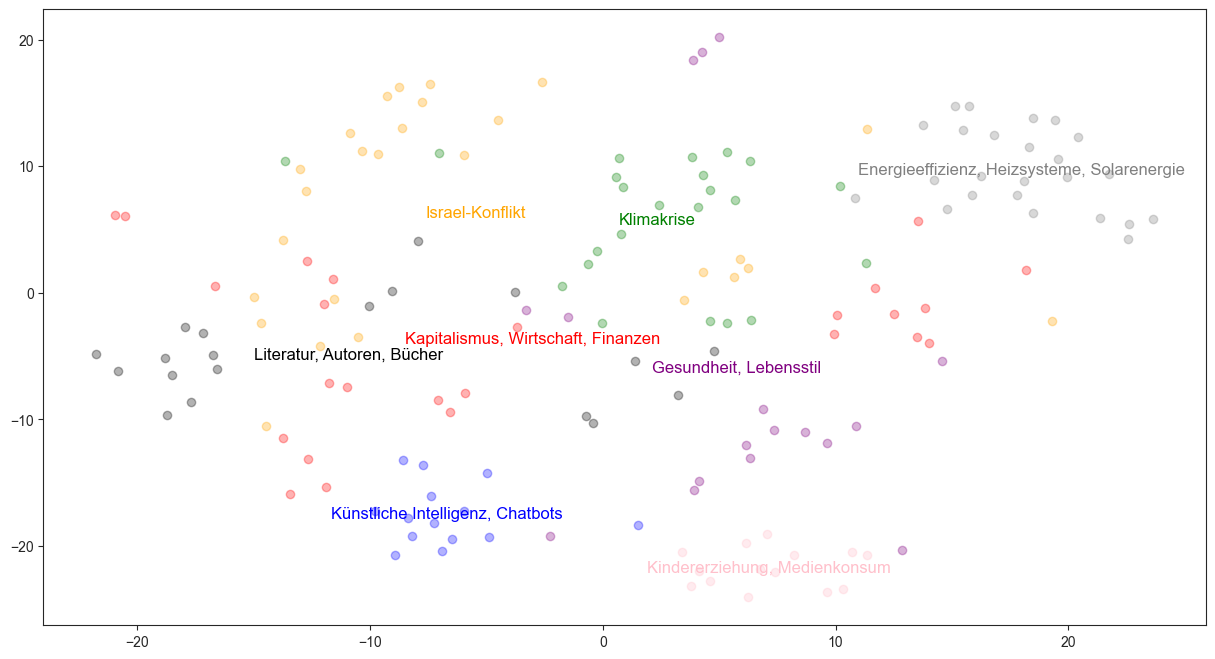

In [24]:
# t-SNE plot for my bookmarks

plt.rcParams['figure.figsize'] = [15, 8]
print(len(filtered_spon_embeddings))

# sort by distance_from_center and select first 5 articles per cluster
#filtered_spon_embeddings.sort_values(by=['Cluster', 'distance_from_center'], inplace=True)
#any_cluster_spon_embeddings = filtered_spon_embeddings.groupby('Cluster').head(5)

any_cluster_spon_embeddings = filtered_spon_embeddings[filtered_spon_embeddings["distance_from_center"] < 0.45]
matrix = np.vstack(any_cluster_spon_embeddings.embedding.values)

print(len(any_cluster_spon_embeddings))

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange", "black", "grey", "pink"]):
    xs = np.array(x)[any_cluster_spon_embeddings.Cluster == category]
    ys = np.array(y)[any_cluster_spon_embeddings.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    # print Cluster_Label and color
    plt.annotate(any_cluster_spon_embeddings.Response[any_cluster_spon_embeddings.Cluster == category].iloc[0], (xs.mean(), ys.mean()), 
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=12,
                 color=color)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, color=color, s=100, marker="")
    

In [25]:
# get similar articles for each cluster

collect_df = []
for i in filtered_spon_embeddings["Cluster"].unique():
    
    print(f'Cluster {i}')
    any_cluster_spon_embeddings = filtered_spon_embeddings[filtered_spon_embeddings["Cluster"] == i]
    any_cluster_spon_embeddings = any_cluster_spon_embeddings[any_cluster_spon_embeddings["distance_from_center"] < 0.4]
    average_embeddings = get_average_embedding(spon_embeddings, any_cluster_spon_embeddings.id)
    similar_articles = find_similar_articles(embedding_space=spon_embeddings, avg_embedding=average_embeddings[1])
    similar_articles["Cluster"] = i
    similar_articles["Cluster_Label"] = any_cluster_spon_embeddings["Response"].iloc[0]
    collect_df.append(similar_articles)
    
collect_df = pd.concat(collect_df)  
collect_df = collect_df.sort_values(by=['cosine_similarity'], ascending=True)  

Cluster 4
Cluster 1
Cluster 3
Cluster 6
Cluster 5
Cluster 2
Cluster 8
Cluster 0
Cluster 7


In [29]:
# print five articles per cluster

check = collect_df[
    (collect_df.publish_date > '2023-12-01') &
    (collect_df.channel != 'International') & 
    (collect_df.heading.str.contains('Die Lage') == False)]

check = check.groupby('Cluster').head(5)

for i in check.Cluster.unique():
    print(f'Cluster {i}: {check[check.Cluster == i].Cluster_Label.iloc[0]}')
    for j in range(3):
        print(check[check.Cluster == i].heading.iloc[j], ": ", check[check.Cluster == i].title.iloc[j], sep='')
    print("=" * 100)
